## Imports e config

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    GridSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay, classification_report, precision_score
)

# Random State
RANDOM_STATE = 42

## Dados

In [ ]:
# https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download
df = pd.read_csv("/diabetes.csv")
X = df.drop("Outcome", axis=1).values
y = df["Outcome"].values

# labels
labels = ["não diabético", "diabético"]

# modelo de treino 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Formas:", "X_train", X_train.shape, "| X_test", X_test.shape)
print("Distribuição de classes (treino):", np.bincount(y_train))
print("Distribuição de classes (teste) :", np.bincount(y_test))

# tamanho dataset
print(len(df))

Formas: X_train (614, 8) | X_test (154, 8)
Distribuição de classes (treino): [400 214]
Distribuição de classes (teste) : [100  54]
768


In [ ]:
#pipeline
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC())
])

#paramgrid
param_grid = [
    {"clf__kernel": ["linear"], "clf__C": [0.01, 0.1, 1, 10, 100]},
    {"clf__kernel": ["rbf"], "clf__C": [0.01, 0.1, 1, 10, 100], "clf__gamma": ["scale", 0.01, 0.001]},
    {"clf__kernel": ["poly", "sigmoid"], "clf__C": [0.01, 0.1, 1, 10, 100]},
]

## GridSearch - KFold = 10

Melhor kernel (Grid kernel): linear
Melhor C 0.1
 Acurácia teste (melhor kernel): 72.08%


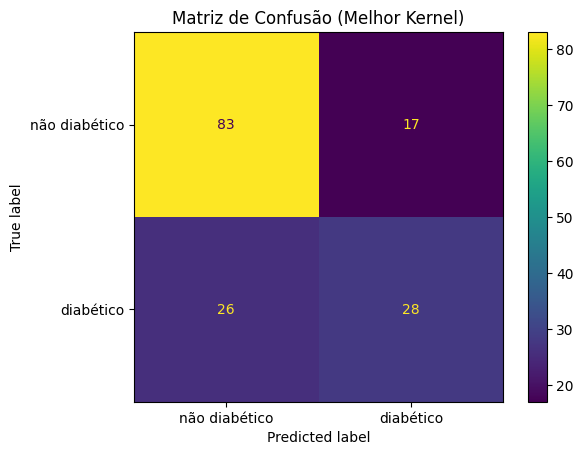

In [ ]:
# KFold setado em 10.
cv10 = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# parametros do GridSearchCV
gs_k10 = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv10,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

# treino do modelo
gs_k10.fit(X_train, y_train)

# extraindo dados sobre o melhor modelo testado
best_kernel = gs_k10.best_params_['clf__kernel']
best_c = gs_k10.best_params_['clf__C']
y_pred = gs_k10.predict(X_test)

# acurácia
acc = accuracy_score(y_test, y_pred)

# mostrando informações
print("Melhor kernel (Grid kernel):", best_kernel)
print("Melhor C", best_c)
print(f" Acurácia teste (melhor kernel): {acc*100:.2f}%")

# matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
plt.title("Matriz de Confusão (Melhor Kernel)")
plt.show()

## GridSearch - StratifiedKFold = 3

Melhor kernel (Grid kernel): rbf
Melhor C 10
Melhor Gamma 0.01
 Acurácia teste (melhor kernel): 75.32%


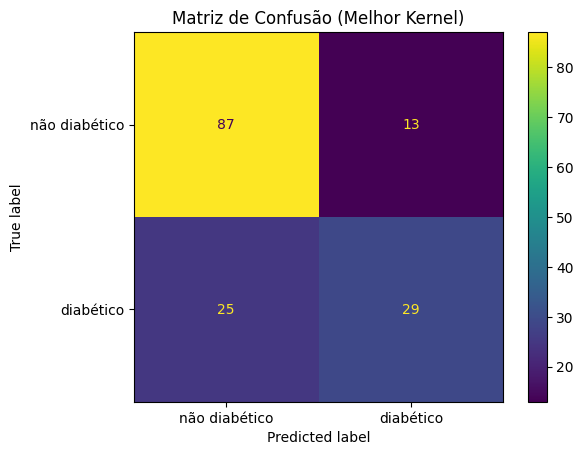

In [ ]:
# StratifiedKFold setado em 3.
cv3  = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# parametros do GridSearchCV
gs_s3 = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv3,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

# treino do modelo
gs_s3.fit(X_train, y_train)

# extraindo dados sobre o melhor modelo testado
best_kernel = gs_s3.best_params_['clf__kernel']
best_c = gs_s3.best_params_['clf__C']
best_gamma = gs_s3.best_params_['clf__gamma']
y_pred = gs_s3.predict(X_test)

# acurácia
acc = accuracy_score(y_test, y_pred)

# mostrando informações
print("Melhor kernel (Grid kernel):", best_kernel)
print("Melhor C", best_c)
print("Melhor Gamma", best_gamma)
print(f" Acurácia teste (melhor kernel): {acc*100:.2f}%")

# matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
plt.title("Matriz de Confusão (Melhor Kernel)")
plt.show()

## Arvore de Decisão


Acurácia (padrão): 72.73%

Melhor combinação de parâmetros (Árvore): {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
Acurácia no teste (Árvore Otimizada): 69.48%


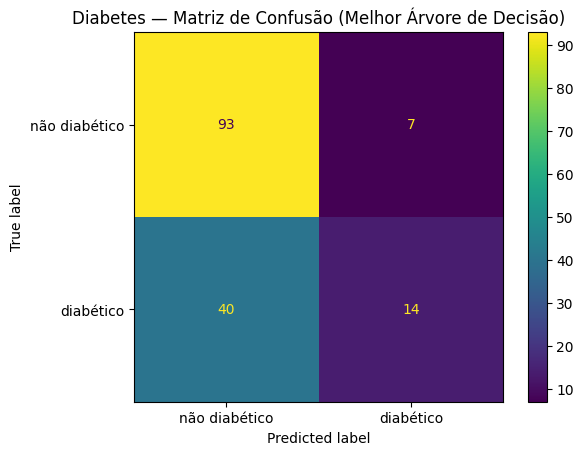

In [ ]:
# Árvore de Decisão

model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
model_tree.fit(X_train, y_train)
y_pred_tree_base = model_tree.predict(X_test)
acc_tree_base = accuracy_score(y_test, y_pred_tree_base)
print(f"Acurácia (padrão): {acc_tree_base*100:.2f}%")

param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

gs_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid_tree,
    cv=cv3,
    n_jobs=-1
)
gs_tree.fit(X_train, y_train)

y_pred_gs_tree = gs_tree.predict(X_test)
acc_gs_tree = accuracy_score(y_test, y_pred_gs_tree)

# resultados da otimização
print("\nMelhor combinação de parâmetros (Árvore):", gs_tree.best_params_)
print(f"Acurácia no teste (Árvore Otimizada): {acc_gs_tree*100:.2f}%")

# matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gs_tree, display_labels=labels)
plt.title("Diabetes — Matriz de Confusão (Melhor Árvore de Decisão)")
plt.show()

Melhores parâmetros (Floresta): {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100}
Acurácia no teste (Floresta): 75.97%


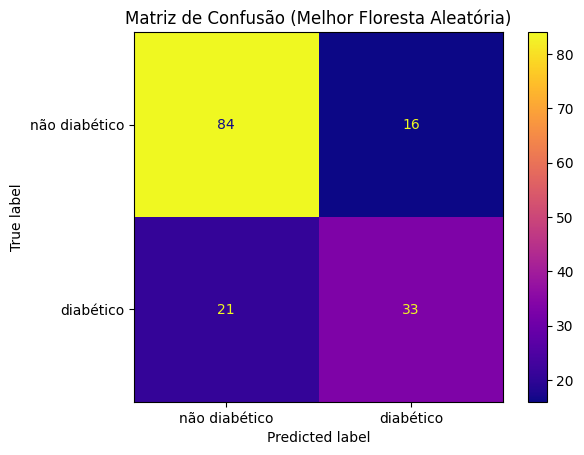

In [ ]:
# Pipeline para Floresta aleatória
pipe_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE))
])

# Grid de parâmetros para a Floresta
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_leaf': [1, 5]
}

# Montando e treinando o GridSearchCV
cv10 = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
gs_rf = GridSearchCV(estimator=pipe_rf, param_grid=param_grid_rf, scoring="accuracy", cv=cv10, n_jobs=-1)
gs_rf.fit(X_train, y_train)

# Avaliação
print("Melhores parâmetros (Floresta):", gs_rf.best_params_)
acc_rf = gs_rf.score(X_test, y_test)
print(f"Acurácia no teste (Floresta): {acc_rf*100:.2f}%")

# Matriz de confusão
ConfusionMatrixDisplay.from_estimator(gs_rf, X_test, y_test, display_labels=labels, cmap="plasma")
plt.title("Matriz de Confusão (Melhor Floresta Aleatória)")
plt.show()

## Hold Out


Hold-out [rbf]
Acurácia: 75.32%  |  F1: 0.6042  |  Recall+: 0.5370

Classification report:
               precision    recall  f1-score   support

não diabético     0.7768    0.8700    0.8208       100
    diabético     0.6905    0.5370    0.6042        54

     accuracy                         0.7532       154
    macro avg     0.7336    0.7035    0.7125       154
 weighted avg     0.7465    0.7532    0.7448       154



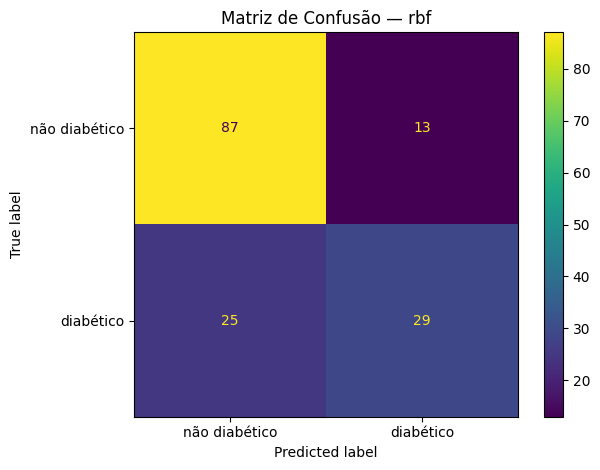

In [ ]:
model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=10, gamma=0.01))
])

model.fit(X_train, y_train)

# previsões no conjunto de teste
y_pred = model.predict(X_test)

# métricas
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

# informações sobre o modelo
print(f"\nHold-out [rbf]")
print(f"Acurácia: {acc*100:.2f}%  |  F1: {f1:.4f}  |  Recall+: {rec:.4f}")
print("\nClassification report:")
print(classification_report (y_test, y_pred, target_names=labels, digits=4))

# matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
plt.title(f"Matriz de Confusão — {best_kernel}")
plt.tight_layout()
plt.show()

## Dados e Gráficos

#### Classification Report

In [ ]:
classes = np.unique(y_test)
name_map = {0: "não diabético", 1: "diabético"}
target_names = [name_map.get(int(c), str(c)) for c in classes]
rep = classification_report(
   y_test, y_pred,
   labels=classes,
   target_names=target_names,
   output_dict=True,
   zero_division=0
)
df = pd.DataFrame(rep).transpose()
ordem = target_names + ["accuracy", "macro avg", "weighted avg"]
df = df.loc[ordem, ["precision", "recall", "f1-score", "support"]]
df = df.round({"precision":4, "recall":4, "f1-score":4})
df["support"] = df["support"].astype(int)
display(df)

,precision,recall,f1-score,support
não diabético,0.7768,0.8700,0.8208,100
diabético,0.6905,0.5370,0.6042,54
accuracy,0.7532,0.7532,0.7532,0
macro avg,0.7336,0.7035,0.7125,154
weighted avg,0.7465,0.7532,0.7448,154


ROC AUC — Linear@K10: 0.827 | RBF@SK3: 0.831
AP (PR AUC) — Linear@K10: 0.706 | RBF@SK3: 0.715


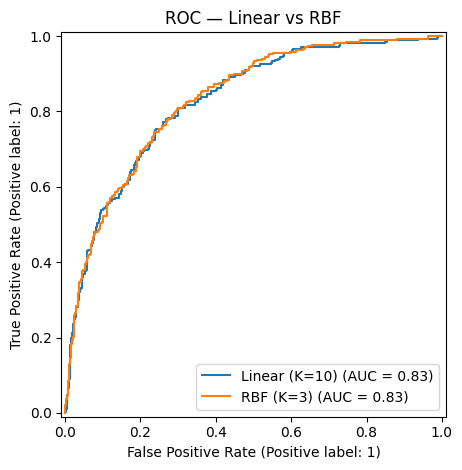

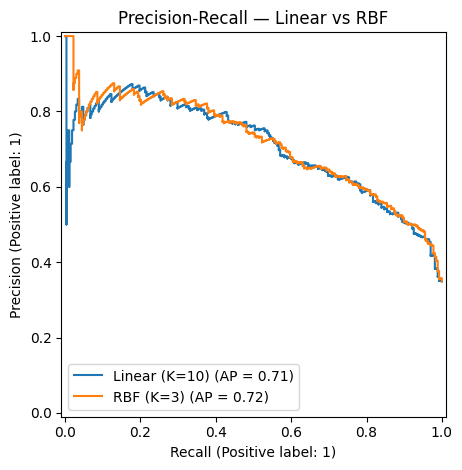

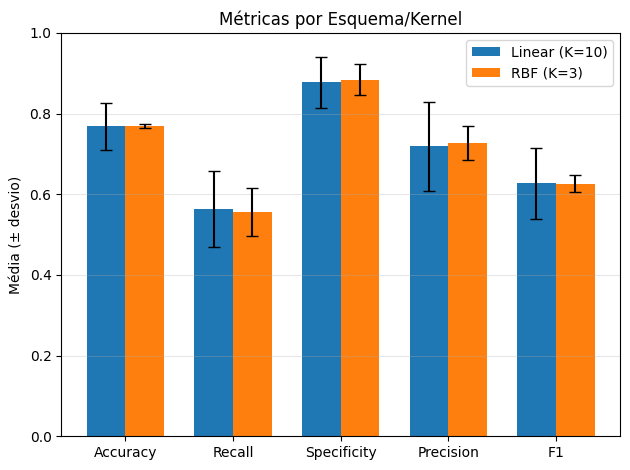

In [ ]:
# ==== Imports ====
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (
    roc_auc_score, RocCurveDisplay,
    average_precision_score, PrecisionRecallDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    make_scorer
)

# ==== Configs/objs ====
cv10 = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv3  = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

svm_linear = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="linear", C=1, gamma="scale", random_state=RANDOM_STATE))
])

svm_rbf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=10, gamma=0.01, random_state=RANDOM_STATE))
])

# ==== Helper: métricas por CV (média ± std) ====
specificity_scorer = make_scorer(recall_score, pos_label=0)

def collect_cv_metrics(model, cv):
    metrics = {}
    metrics["accuracy"]   = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    metrics["precision"]  = cross_val_score(model, X, y, cv=cv, scoring="precision")
    metrics["recall"]     = cross_val_score(model, X, y, cv=cv, scoring="recall")       # sensibilidade (classe positiva)
    metrics["specificity"]= cross_val_score(model, X, y, cv=cv, scoring=specificity_scorer) # sensibilidade da classe negativa
    metrics["f1"]         = cross_val_score(model, X, y, cv=cv, scoring="f1")
    return metrics

def summarize(metrics):
    return {k: (v.mean(), v.std()) for k, v in metrics.items()}

# ==== 1) ROC: usa decision_function (ou predict_proba fallback) ====
def get_scores_for_curves(model, cv):
    # tenta decision_function
    try:
        scores = cross_val_predict(model, X, y, cv=cv, method="decision_function")
        return scores
    except:
        # fallback: probability=True
        m = Pipeline(model.steps[:-1] + [("clf", SVC(**{**model.named_steps["clf"].get_params(), "probability": True}))])
        probs = cross_val_predict(m, X, y, cv=cv, method="predict_proba")[:, 1]
        return probs

scores_lin = get_scores_for_curves(svm_linear, cv10)
scores_rbf = get_scores_for_curves(svm_rbf,    cv3)

# ROC plot
fig_roc, ax_roc = plt.subplots()
RocCurveDisplay.from_predictions(y, scores_lin, name="Linear (K=10)", ax=ax_roc)
RocCurveDisplay.from_predictions(y, scores_rbf, name="RBF (K=3)", ax=ax_roc)
ax_roc.set_title("ROC — Linear vs RBF")
plt.tight_layout()

# ==== 2) Precision-Recall Curve + AP ====
fig_pr, ax_pr = plt.subplots()
PrecisionRecallDisplay.from_predictions(y, scores_lin, name="Linear (K=10)", ax=ax_pr)
PrecisionRecallDisplay.from_predictions(y, scores_rbf, name="RBF (K=3)", ax=ax_pr)
ax_pr.set_title("Precision-Recall — Linear vs RBF")
plt.tight_layout()

# AP (Average Precision) e AUC ROC numéricos (se quiser exibir no console)
try:
    auc_lin = roc_auc_score(y, scores_lin)
    auc_rbf = roc_auc_score(y, scores_rbf)
except:
    # se scores forem probs, tudo certo; se forem decision_function tbm funciona
    auc_lin = roc_auc_score(y, scores_lin)
    auc_rbf = roc_auc_score(y, scores_rbf)
ap_lin  = average_precision_score(y, scores_lin)
ap_rbf  = average_precision_score(y, scores_rbf)
print(f"ROC AUC — Linear@K10: {auc_lin:.3f} | RBF@SK3: {auc_rbf:.3f}")
print(f"AP (PR AUC) — Linear@K10: {ap_lin:.3f} | RBF@SK3: {ap_rbf:.3f}")

# ==== 3) Barplot de métricas médias (± desvio) ====
m_lin = summarize(collect_cv_metrics(svm_linear, cv10))
m_rbf = summarize(collect_cv_metrics(svm_rbf,    cv3))

metric_names = ["accuracy", "recall", "specificity", "precision", "f1"]
lin_means = [m_lin[m][0] for m in metric_names]
lin_stds  = [m_lin[m][1] for m in metric_names]
rbf_means = [m_rbf[m][0] for m in metric_names]
rbf_stds  = [m_rbf[m][1] for m in metric_names]

x = np.arange(len(metric_names))
w = 0.36

fig_bar, ax_bar = plt.subplots()
ax_bar.bar(x - w/2, lin_means, yerr=lin_stds, width=w, capsize=4, label="Linear (K=10)")
ax_bar.bar(x + w/2, rbf_means, yerr=rbf_stds, width=w, capsize=4, label="RBF (K=3)")
ax_bar.set_xticks(x, [m.capitalize() for m in metric_names])
ax_bar.set_ylim(0, 1)
ax_bar.set_ylabel("Média (± desvio)")
ax_bar.set_title("Métricas por Esquema/Kernel")
ax_bar.legend()
ax_bar.grid(True, axis="y", alpha=0.3)
plt.tight_layout()

plt.show()


In [ ]:
# (opcional) !pip install plotly scikit-learn pandas numpy

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# === Dados ===
# Arquivo deve estar no mesmo diretório com nome "diabetes.csv" (Pima Indians Diabetes)
df = pd.read_csv("diabetes.csv")

feat3d = ("Glucose", "BMI", "Age")  # eixos do 3D
X = df[list(feat3d)].to_numpy()
y = df["Outcome"].to_numpy()  # 0 = não diabético, 1 = diabético

# === Padronização ===
sc = StandardScaler()
Xs = sc.fit_transform(X)

# === Treino SVM linear ===
clf = SVC(kernel="linear", C=10)
clf.fit(Xs, y)

# === Coeficientes do hiperplano ===
w = clf.coef_[0]
b = clf.intercept_[0]

# === Grid p/ plano e margens ===
x_range = np.linspace(Xs[:, 0].min(), Xs[:, 0].max(), 30)
y_range = np.linspace(Xs[:, 1].min(), Xs[:, 1].max(), 30)
xx, yy = np.meshgrid(x_range, y_range)

# z = -(b + w0*x + w1*y) / w2
# (se w[2] for ~0 o problema fica degenerado p/ este trio de features)
eps = 1e-9
den = w[2] if abs(w[2]) > eps else np.sign(w[2]) * eps
zz   = -(b + w[0]*xx + w[1]*yy) / den
zz_m1 = -(b - 1 + w[0]*xx + w[1]*yy) / den  # margem -1
zz_p1 = -(b + 1 + w[0]*xx + w[1]*yy) / den  # margem +1

# === Plot ===
fig = go.Figure()

# Pontos por classe (cores fixas p/ legenda clara)
fig.add_trace(go.Scatter3d(
    x=Xs[y == 0, 0], y=Xs[y == 0, 1], z=Xs[y == 0, 2],
    mode="markers",
    marker=dict(size=4, color="royalblue", opacity=0.9),
    name="Não diabético (0)",
    hovertemplate=(
        f"{feat3d[0]}(std)=%{{x:.2f}}"
        f"{feat3d[1]}(std)=%{{y:.2f}}"
        f"{feat3d[2]}(std)=%{{z:.2f}}Classe 0"
    )
))
fig.add_trace(go.Scatter3d(
    x=Xs[y == 1, 0], y=Xs[y == 1, 1], z=Xs[y == 1, 2],
    mode="markers",
    marker=dict(size=4, color="crimson", opacity=0.9),
    name="Diabético (1)",
    hovertemplate=(
        f"{feat3d[0]}(std)=%{{x:.2f}}"
        f"{feat3d[1]}(std)=%{{y:.2f}}"
        f"{feat3d[2]}(std)=%{{z:.2f}}Classe 1"
    )
))

# Hiperplano
fig.add_trace(go.Surface(
    x=x_range, y=y_range, z=zz,
    opacity=0.5, showscale=False, colorscale="Greys",
    name="Hiperplano (w·x + b = 0)",
    hoverinfo="skip"
))

# Margens ±1
fig.add_trace(go.Surface(
    x=x_range, y=y_range, z=zz_m1,
    opacity=0.28, showscale=False, colorscale="Blues",
    name="Margem -1",
    hoverinfo="skip"
))
fig.add_trace(go.Surface(
    x=x_range, y=y_range, z=zz_p1,
    opacity=0.28, showscale=False, colorscale="Reds",
    name="Margem +1",
    hoverinfo="skip"
))

# Layout + legenda
fig.update_layout(
    title="SVM Linear — Hiperplano 3D e Margens (±1) — Pima Indians Diabetes",
    scene=dict(
        xaxis_title=f"{feat3d[0]} (std)",
        yaxis_title=f"{feat3d[1]} (std)",
        zaxis_title=f"{feat3d[2]} (std)",
        aspectmode="cube"
    ),
    legend=dict(
        title="Legenda",
        itemsizing="constant",
        bgcolor="rgba(255,255,255,0.6)"
    ),
    margin=dict(l=0, r=0, t=60, b=0)
)

fig.show()
